# Part-swap demo for paper "Motion Supervised co-part Segmentation"

**Clone repository**

In [122]:
!git clone https://github.com/AliaksandrSiarohin/motion-cosegmentation motion-co-seg

Cloning into 'motion-co-seg'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 106 (delta 20), reused 13 (delta 13), pack-reused 75
Receiving objects: 100% (106/106), 42.61 MiB | 34.22 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [123]:
cd motion-co-seg/

/content/motion-co-seg/motion-co-seg


**Mount your Google drive folder on Colab**

In [124]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [129]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2022-07-20 08:56:57--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  78.3MB/s    in 0.8s    

2022-07-20 08:56:58 (78.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [125]:
import torch
print(torch.__version__)

1.12.0+cu113


In [126]:
import scipy
import scipy.ndimage
import dlib
from PIL import Image
import PIL

def get_landmark(filepath, predictor):
  detector = dlib.get_frontal_face_detector()
  img = dlib.load_rgb_image(filepath)
  dets = detector(img, 1)

  for k, d in enumerate(dets):
    shape = predictor(img, d)

  t = list(shape.parts())
  a = []
  for tt in t:
    a.append([tt.x, tt.y])
  lm = np.array(a)
  return lm

def align_face(filepath, predictor,x_scale=1, y_scale=1):

  lm = get_landmark(filepath, predictor)

  lm_chin = lm[0: 17]  # left-right
  lm_eyebrow_left = lm[17: 22]  # left-right
  lm_eyebrow_right = lm[22: 27]  # left-right
  lm_nose = lm[27: 31]  # top-down
  lm_nostrils = lm[31: 36]  # top-down
  lm_eye_left = lm[36: 42]  # left-clockwise
  lm_eye_right = lm[42: 48]  # left-clockwise
  lm_mouth_outer = lm[48: 60]  # left-clockwise
  lm_mouth_inner = lm[60: 68]  # left-clockwise

  # Calculate auxiliary vectors.
  eye_left = np.mean(lm_eye_left, axis=0)
  eye_right = np.mean(lm_eye_right, axis=0)
  eye_avg = (eye_left + eye_right) * 0.5
  eye_to_eye = eye_right - eye_left
  mouth_left = lm_mouth_outer[0]
  mouth_right = lm_mouth_outer[6]
  mouth_avg = (mouth_left + mouth_right) * 0.5
  eye_to_mouth = mouth_avg - eye_avg

  # Choose oriented crop rectangle.
  x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
  x /= np.hypot(*x)
  x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
  x *= x_scale
  y = np.flipud(x) * [-y_scale, y_scale]
  c = eye_avg + eye_to_mouth * 0.1
  quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
  qsize = np.hypot(*x) * 2

  # read image
  img = Image.open(filepath)

  output_size = 256
  transform_size = 256
  enable_padding = True

  # Shrink.
  shrink = int(np.floor(qsize / output_size * 0.5))
  if shrink > 1:
    rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    img = img.resize(rsize, PIL.Image.ANTIALIAS)
    quad /= shrink
    qsize /= shrink

  # Crop.
  border = max(int(np.rint(qsize * 0.1)), 3)
  crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
      int(np.ceil(max(quad[:, 1]))))
  crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
      min(crop[3] + border, img.size[1]))
  if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
    img = img.crop(crop)
    quad -= crop[0:2]

  # Pad.
  pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
        int(np.ceil(max(quad[:, 1]))))
  pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
        max(pad[3] - img.size[1] + border, 0))
  if enable_padding and max(pad) > border - 4:
    pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    h, w, _ = img.shape
    y, x, _ = np.ogrid[:h, :w, :1]
    mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
              1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
    blur = qsize * 0.02
    img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
    img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    quad += pad[:2]

  # Transform.
  img = img.transform((transform_size, transform_size), Image.QUAD, (quad + 0.5).flatten(), Image.BILINEAR)
  if output_size < transform_size:
    img = img.resize((output_size, output_size), Image.ANTIALIAS)

  # Save aligned image.
  return img


def run_alignment(image_path):
  import dlib
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  src_img = Image.open(image_path)
  aligned_image = align_face(image_path, predictor=predictor,x_scale=1.1, y_scale=1.1)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

**Add shortcut of https://drive.google.com/open?id=1SsBifjoM_qO0iFzb8wLlsz_4qW2j8dZe to your google drive.**


**Load target video and source image**

In [141]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
from argparse import Namespace
import time
import sys
import pprint

warnings.filterwarnings("ignore")

image_path = '/content/gdrive/MyDrive/overlay_bild_8.jpg'
source_image = imageio.imread(image_path) # here you need to put the path of your image

#source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/16.png')
target_video = imageio.mimread('/content/gdrive/MyDrive/output_video_12.mp4', memtest=False)

#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

def display(source, target, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(target)):
        cols = [source]
        cols.append(target[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, target_video).to_html5_video())

### Align Image

Note: in this notebook we'll run alignment on the input image. 

Aligned image has shape: (256, 256)


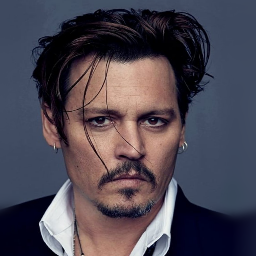

In [142]:
input_image = run_alignment(image_path)
input_image.resize((256, 256))
input_image_RGB = input_image.convert('RGB')
input_image_RGB = input_image_RGB.save(f'/content/gdrive/MyDrive/data3/cropped_input_image.jpg') 
input_image

**Loading checkpoints with 10 parts**

In [137]:
from part_swap import load_checkpoints

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-10segments.yaml', 
                                               checkpoint='/content/gdrive/My Drive/motion-supervised-co-segmentation/vox-10segments.pth.tar',
                                               blend_scale=1)

In [115]:
count = 1
path_list = []

**Visualizing the segmentation**

(256, 256)
(256, 256, 11)
1
(256, 256)


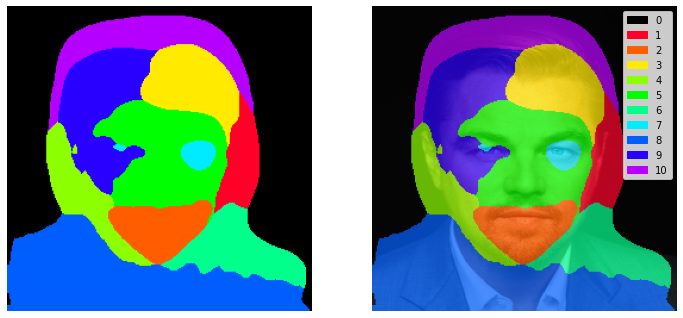

In [138]:

import torch
import torch.nn.functional as F
import io
from scipy.io import savemat

import matplotlib.patches as mpatches



def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        inp = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda()
        if supervised:
            inp = F.interpolate(inp, size=(512, 512))
            inp = (inp - network.mean) / network.std
            mask = torch.softmax(network(inp)[0], dim=1)
            mask = F.interpolate(mask, size=image.shape[:2])
        else:
            mask = network(inp)['segmentation']
            mask = F.interpolate(mask, size=image.shape[:2], mode='bilinear')
    
    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()
    
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
    print(mask.shape)
    
    color_mask = 0
    patches = []
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i+1)] * color.reshape(1, 1, 3)
    
    #fig, ax = plt.subplots(1)
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].imshow(color_mask)
    #ax.imshow(0.3 * image + 0.7 * color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    print(count)
    
    #path_list.append(f'/content/gdrive/MyDrive/data5/frame{count}.jpg')
    ax[1].legend(handles=patches)
    #ax.legend(handles=patches)
    #ax.axis('off')
    #fig.savefig(f'/content/gdrive/MyDrive/data5/frame{count}.jpg', bbox_inches="tight")
    ax[0].axis('off')
    ax[1].axis('off')
    

print(input_image.size)
visualize_segmentation(np.array(input_image)/255.0, segmentation_module, hard=True)
print(input_image.size)
plt.show()
count = 1

In [139]:
#from moviepy.editor import VideoFileClip
#from moviepy.editor import *
#from pathlib import Path
#from datetime import timedelta
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#import matplotlib.patches as patches
#import os

#frames_list=[]


#SAVING_FRAMES_PER_SECOND = 24


#for image in os.listdir('/content/gdrive/MyDrive/data4/'):
  #os.remove(f'/content/gdrive/MyDrive/data4/{image}')
  #print(f' Removed image at /content/gdrive/MyDrive/data/{image}')

#for image in os.listdir('/content/gdrive/MyDrive/data5/'):
  #os.remove(f'/content/gdrive/MyDrive/data5/{image}')
  #print(f' Removed image at /content/gdrive/MyDrive/data/{image}')



#video = VideoFileClip("/content/gdrive/MyDrive/output_video_12.mp4")
#saving_frames_per_second = min(video.fps, SAVING_FRAMES_PER_SECOND)
#step = 1 / video.fps if saving_frames_per_second == 0 else 1 / saving_frames_per_second


#counter = 0;

#for current_duration in np.arange(0, video.duration, step):
   #counter+=1
   #frame_filename = os.path.join("/content/gdrive/MyDrive/", f"data4/frame{counter}.jpg")
   #video.save_frame(frame_filename, current_duration)



In [118]:
#print(input_image.size)



#for image in os.listdir('/content/gdrive/MyDrive/data/'):
  #print(image)
  #i_image = run_alignment(f'/content/gdrive/MyDrive/data4/{image}')
  #i_image.resize((256, 256))
  #i_image_RGB = i_image.convert('RGB')
  #count+=1
  #visualize_segmentation(np.array(i_image_RGB)/255.0, segmentation_module, hard=True)


Output hidden; open in https://colab.research.google.com to view.

In [121]:
#img_clips = []
#for img_path in path_list:

 # slide = ImageClip(img_path,duration=0.042)
  #img_clips.append(slide)

#video_slides = concatenate_videoclips(img_clips, method='compose')

##video_slides.write_videofile("/content/gdrive/MyDrive/masked_video_2.mp4", fps=24)

[MoviePy] >>>> Building video /content/gdrive/MyDrive/masked_video_2.mp4
[MoviePy] Writing video /content/gdrive/MyDrive/masked_video_2.mp4


100%|██████████| 237/237 [00:01<00:00, 205.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/masked_video_2.mp4 



In [140]:
from part_swap import make_video


predictions = make_video(swap_index=[0,1,2,3,4,5,6,7,8,9,10], source_image = np.array(input_image)/255.0, target_video = target_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
HTML(display(source_image, target_video, predictions).to_html5_video())


100%|██████████| 236/236 [00:11<00:00, 20.37it/s]


In [ ]:
# Saving result video
from skimage import img_as_ubyte
imageio.mimsave('/content/gdrive/MyDrive/face_swap_video_13.mp4', [img_as_ubyte(frame) for frame in predictions], fps=30)